In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import string
import os
from tensorflow.keras.regularizers import l2
import numpy as np

tf.random.set_seed(42)

2024-09-18 15:11:13.293440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-18 15:11:13.307922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-18 15:11:13.312215: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-18 15:11:13.322662: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 15:11:13.947506: W tensorflow/compiler/tf2

In [2]:
def preprocess(array):
    """
    Нормализует предоставленный массив и преобразует его в соответствующий формат.
    """
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), *image_size))
    return array

In [3]:
def display(array1, array2 = None):
    """
    Отображает три случайных изображения из каждого из предоставленных массивов.
    """
    n = 3
    # indices = np.random.randint(len(array1), size=n)
    indices = [0,1,2]
    plt.figure(figsize=(20, 4))
    
    if array2 is None:
        images1 = array1[indices, :]
        for i, image1 in enumerate(images1):
            ax = plt.subplot(2, n, i + 1)
            plt.imshow(image1.reshape(image_size[1], image_size[0], image_size[2]), cmap='gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
        plt.show()
        
        return 
    
    images1 = array1[indices, :]
    images2 = array2[indices, :]


    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(image_size[1], image_size[0], image_size[2]), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(image_size[1], image_size[0], image_size[2]), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

In [4]:
image_size = (256, 64, 1)

In [5]:
symbols = string.ascii_uppercase + "0123456789" # All symbols captcha can contain
num_symbols = len(symbols)

In [6]:
n_samples = len(os.listdir('../captcha/canonic_captcha'))
X = np.zeros((n_samples, 64, 256, 1)) #1070*50*200
y = np.zeros((6, n_samples, num_symbols)) #5*1070*36

for i, pic in enumerate(os.listdir('../captcha/canonic_captcha')):
    # Read image as grayscale
    img = cv2.imread(os.path.join('../captcha/canonic_captcha', pic), cv2.IMREAD_GRAYSCALE)
    pic_target = pic[:-4]
    if len(pic_target) < 7:
        # Scale and reshape image
        if img is not None:
            img_cropped = img[:, 10:-10]
            img = cv2.resize(img_cropped, (256, 64))
            _, img = cv2.threshold(img, 211, 255, cv2.THRESH_BINARY_INV)
            img = img / 255.0
            img = np.reshape(img, (64, 256, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((6, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
            
X = np.array(X)
y = np.array(y)

FileNotFoundError: [Errno 2] No such file or directory: '../captcha/canonic_captcha'

In [7]:
print(X.shape, y.shape)
X_train, y_train = X[:1085], y[:, :1085]
X_test, y_test = X[1085:], y[:, 1085:]
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1085, 64, 256, 1) (6, 1085, 36)
(1085, 64, 256, 1) (6, 1085, 36)
(0, 64, 256, 1) (6, 0, 36)


In [8]:
def y_show(res):
    ans = np.reshape(res, (6, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 5

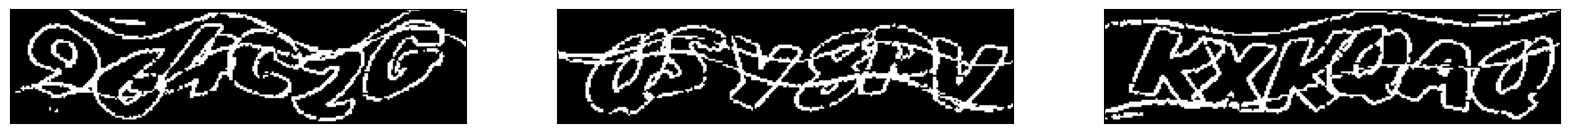

964C2G QSY8PV KXKQAQ


In [9]:
display(X_train)
print(y_show(y_train[:, 0]), y_show(y_train[:, 1]), y_show(y_train[:, 2]))

In [10]:
from tensorflow.keras import layers, Model
from tensorflow.keras.initializers import HeNormal, GlorotUniform

def create_model():
    img = layers.Input(shape=(64, 256, 1))
    
    # Применяем HeNormal инициализатор к первому сверточному слою
    conv1 = layers.Conv2D(16, (3, 3), padding='same', activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))(img)
    bn1 = layers.BatchNormalization()(conv1)
    mp1 = layers.MaxPooling2D(padding='same')(bn1)
    
    # Применяем HeNormal инициализатор к первому сверточному слою
    conv2 = layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))(mp1)
    bn2 = layers.BatchNormalization()(conv2)
    mp2 = layers.MaxPooling2D(padding='same')(bn2)
    
    # Применяем GlorotUniform инициализатор ко второму сверточному слою
    conv3 = layers.Conv2D(64, (3, 3), padding='same', activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))(mp2)
    bn3 = layers.BatchNormalization()(conv3)
    mp3 = layers.MaxPooling2D(padding='same')(bn3)
    
    # Применяем HeNormal к третьему сверточному слою
    conv4 = layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))(mp3)
    bn4 = layers.BatchNormalization()(conv4)
    mp4 = layers.MaxPooling2D(padding='same')(bn4)
    
    flat = layers.Flatten()(mp4)
    outs = []
    for _ in range(6):
        dens1 = layers.Dense(128, activation='relu', kernel_initializer=HeNormal(), kernel_regularizer=l2(0.01))(flat)
        drop = layers.Dropout(0.6)(dens1)
        res = layers.Dense(num_symbols, activation='softmax', kernel_initializer=GlorotUniform())(drop)
        outs.append(res)
    
    model = Model(img, outs)
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        metrics=["accuracy"]*6
    )
    return model

In [11]:
model=create_model()

I0000 00:00:1725540242.519176  249530 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725540242.548765  249530 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725540242.548967  249530 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1725540242.549775  249530 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [13]:
# from tensorflow.keras.models import load_model
# 
# # Загрузка модели из файла H5
# model = load_model('models/last_model.keras')
hist = model.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4], y_train[5]],
                 batch_size=8,
                 epochs=1200,
                 verbose=1, 
                 validation_split=0.2
                 )

Epoch 1/1200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - dense_11_accuracy: 0.9966 - dense_11_loss: 0.0162 - dense_1_accuracy: 0.9975 - dense_1_loss: 0.0097 - dense_3_accuracy: 0.9962 - dense_3_loss: 0.0150 - dense_5_accuracy: 0.9949 - dense_5_loss: 0.0236 - dense_7_accuracy: 0.9913 - dense_7_loss: 0.0248 - dense_9_accuracy: 0.9972 - dense_9_loss: 0.0083 - loss: 1.1656 - val_dense_11_accuracy: 0.8848 - val_dense_11_loss: 0.4291 - val_dense_1_accuracy: 0.9309 - val_dense_1_loss: 0.2417 - val_dense_3_accuracy: 0.8664 - val_dense_3_loss: 0.5616 - val_dense_5_accuracy: 0.8387 - val_dense_5_loss: 0.6772 - val_dense_7_accuracy: 0.8018 - val_dense_7_loss: 0.8889 - val_dense_9_accuracy: 0.8710 - val_dense_9_loss: 0.5399 - val_loss: 4.2565
Epoch 2/1200
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - dense_11_accuracy: 0.9979 - dense_11_loss: 0.0119 - dense_1_accuracy: 0.9971 - dense_1_loss: 0.0130 - dense_3_accuracy: 0.9941 - dense_3_loss: 0.0178 - dense_5_accuracy: 0.9923 - dense_5_loss: 0.0175 - 


KeyboardInterrupt



KeyError: 'last_loss'

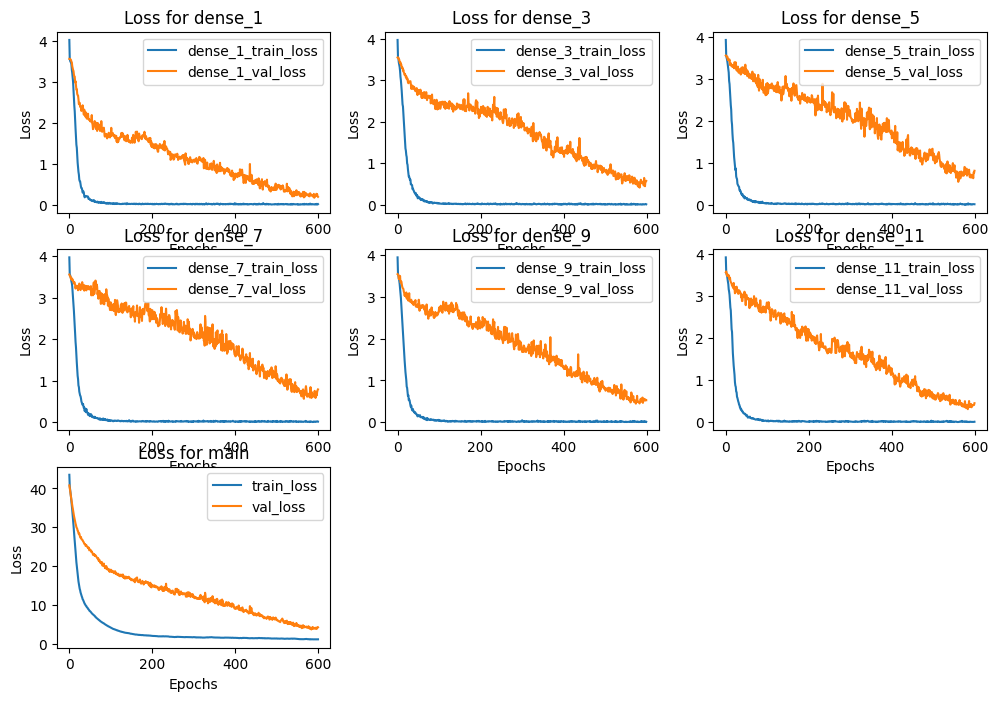

In [14]:
model.save('models/model_v0.0.2.keras')

output_names = ['dense_1', 'dense_3', 'dense_5', 'dense_7', 'dense_9', 'dense_11', 'last']

# Строим графики
plt.figure(figsize=(12, 8))

for i, name in enumerate(output_names):
    
    if 'last' == name:
        
        plt.subplot(3, 3, i+1)
    
        # График лосса на обучении
        plt.plot(hist.history[f'loss'], label=f'train_loss')
        
        # График лосса на валидации
        plt.plot(hist.history[f'val_loss'], label=f'val_loss')
        
        plt.title(f'Loss for main')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        
    plt.subplot(3, 3, i+1)
    
    # График лосса на обучении
    plt.plot(hist.history[f'{name}_loss'], label=f'{name}_train_loss')
    
    # График лосса на валидации
    plt.plot(hist.history[f'val_{name}_loss'], label=f'{name}_val_loss')
    
    plt.title(f'Loss for {name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
        
plt.tight_layout()
plt.show()

In [15]:
def predict(img):
    res = np.array(model.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (6, 36))
    l_ind = []
    probs = []
    for a in ans:
        l_ind.append(np.argmax(a))
        #probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt#, sum(probs) / 6

In [16]:
n_samples = len(os.listdir('../captcha/canonic_test'))
X = np.zeros((n_samples, 64, 256, 1)) #1070*50*200
y = np.zeros((6, n_samples, num_symbols)) #5*1070*36

for i, pic in enumerate(os.listdir('../captcha/canonic_test')):
    # Read image as grayscale
    img = cv2.imread(os.path.join('../captcha/canonic_test', pic), cv2.IMREAD_GRAYSCALE)
    pic_target = pic[:-4]
    if len(pic_target) < 7:
        # Scale and reshape image
        if img is not None:
            img_cropped = img[:, 10:-10]
            img = cv2.resize(img_cropped, (256, 64))
            _, img = cv2.threshold(img, 211, 255, cv2.THRESH_BINARY_INV)
            img = img / 255.0
            img = np.reshape(img, (64, 256, 1))
            # Define targets and code them using OneHotEncoding
            targs = np.zeros((6, num_symbols))
            for j, l in enumerate(pic_target):
                ind = symbols.find(l)
                targs[j, ind] = 1
            X[i] = img
            y[:, i] = targs
            
X_test = np.array(X)
y_test = np.array(y)



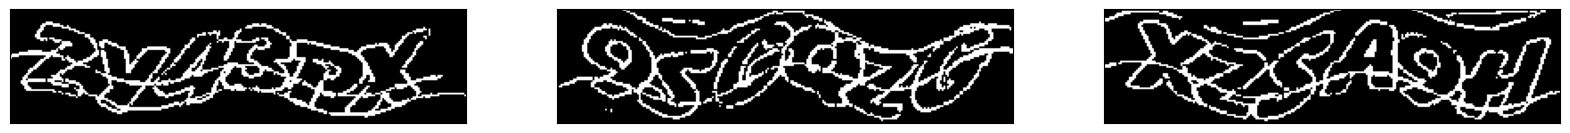

ZY43PX 9SGQZG XZSA9H
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 643ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
ZY43PX 9SGQZG XZSA9H


In [17]:
display(X_test)
print(y_show(y[:, 0]), y_show(y[:, 1]), y_show(y[:, 2]))
print(predict(X_test[0]), predict(X_test[1]), predict(X_test[2]))